# Ensemble Methods Advanced concepts

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from sklearn import grid_search, cross_validation, metrics, ensemble
import arff
from addutils import css_notebook
import matplotlib.pyplot as plt
%matplotlib inline
css_notebook()

## 1 Introduction

This notebook we discuss advanced techniques that can be used with ensemble methods. Briefly this methods are:

- OOB estimates
- feature importance
- proximity plot

In the last part of the notebook, we introduce the `randomForest` package for the **R** language. It is a standard implementation of the Random Forest algorithm but it has few differences w.r.t. the implementation of scikit-learn. The main concept that will be introduced are:

- alternative method for variable importance
- feature selection
- proximity plot

## 2 Out of Bag Estimates

When using **ensemble methods based upon Bagging**, i.e. using sampling with replacement, part of the training set remains unused. For each classifier in the ensemble, a different part of the training set is left out. This left out portion can be used to **estimate the generalization error without having to rely on a separate Validation Set**. This estimate comes “for free” as no additional data is needed and can be used for model selection. 

This is currently implemented in the following classes:

  * `RandomForestClassifier` / `RandomForestRegressor`
  * `ExtraTreesClassifier` / `ExtraTreesRegressor`
  * `GradientBoostingClassifier` / `GradientBoostingRegressor` 

**Remark**

In GradientBoosting OOB score is available only when `subsample` $< 1.0$. It can be used for a different purpose, that is finding the optimal number of boosting iterations, but it is a pessimistic estimator of the true testing error. Use it only for saving computataional time since, for example, cross-validation is more demanding.

### 2.1 Phishing Websites Data Set
For testing oob score properties of ensemble method we used a publicly available dataset. The dataset is the Phishing Websites Data Set and can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Phishing+Websites). It refers to a training dataset for testing machine learning and data mining techiniques for discovering phishing websites. It is used in a series of publications available at the web page of the dataset.

In [3]:
#load the dataset
data = arff.load(open('example_data/Training Dataset.arff', 'rb'))
print "Keys: "
for k in data.keys():
    print "- " + k

Keys: 
- attributes
- relation
- description
- data


In "attributes" are stored the column names while actual data is stored in "data". The dataset is further divided into training and test set to compare OOB score with CV and held out set.

In [4]:
#use the dataset to build a dataframe
cols = [at[0] for at in data['attributes']]
df = pd.DataFrame(data['data'], dtype=int, columns=cols)
print "Shape of the data: {0}".format(df.shape)
target = df.iloc[:,-1]
train = df.iloc[:,:-1]
#split the dataframe in train / test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, 
                                                                     target, 
                                                                     test_size=0.2)
print "Training set / Test set number of samples: {0}, {1}".format(X_train.shape[0], 
                                                                   X_test.shape[0])
print "Number of features: {0}".format(X_train.shape[1])

Shape of the data: (11055, 31)
Training set / Test set number of samples: 8844, 2211
Number of features: 30


### 2.2 OOB estimate Random Forest
Test OOB score against cross-validation and test set. In order to perform OOB score calculation the option oob_score must be set to True.

In [5]:
t0 = time()
rfc = ensemble.RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rfc.fit(X_train, y_train)
print 'RF fit done in %0.3f[s]' %(time() - t0)

t0 = time()
cv_score = cross_validation.cross_val_score(rfc, train, target, cv=10)
print 'CV done in %0.3f[s]' %(time() - t0)

RF fit done in 0.998[s]
CV done in 12.027[s]


As can be seen in this example, using CV to measure the score takes time and it is similar to that obtained from OOB samples, that comes with the algorithm at no additional computational costs.

In [6]:
print 'Score comparison:'
print 'F1 score (on the test set): %f' % metrics.f1_score(rfc.predict(X_test), y_test)
print 'OOB score: %f' % rfc.oob_score_
print 'CV score (on the entire training set): %f' % cv_score.mean()

Score comparison:
F1 score (on the test set): 0.973566
OOB score: 0.971280
CV score (on the entire training set): 0.972043


### 2.3 OOB estimate Gradient Boosting

Accuracy: 0.9720


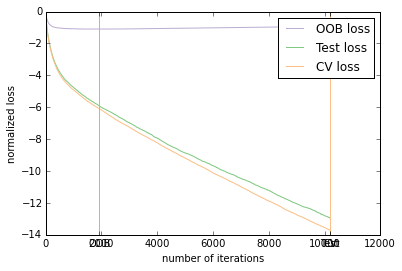

In [7]:
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 10200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1

def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_folds=3):
    cv = cross_validation.KFold(n=X_train.shape[0], n_folds=n_folds)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv:
        cv_clf.fit(X_train.iloc[train], y_train.iloc[train])
        val_scores += heldout_score(cv_clf, X_train.iloc[test], y_train.iloc[test])
    val_scores /= n_folds
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

## 3 Feature importance evaluation

Ensemble methods can provide a measure of importance for each feature in the dataset. This measure can be used to asses how much the feature is important in predicting the response and thus to select the most important features and reduce dimensionality. 

Random Forests have two ways to assign a measure of importance. In scikit-learn feature importance is provided by looking at each split in each tree. The importance of the splitting variable is proportional to the improvement to the gini index given by that split and it is accumulated (for each variable) over all the trees in the forest. The other method proposed in the original paper uses the OOB samples to construct the measure. In practice when a given tree is constructed the OOB samples are passed down the tree and the prediction accuracy is recorded. Then a variable is chosen and its values are permuted (in the OOB samples) and the accuracy is computed again. A decrease in accuracy obtained by this permutation is averaged over all tress for each variable and it provides the importance of that variable (the higher the decreas the higher the importance). This method has better statistical properties with respect to the first and it is used in other implementation such as package randomForest in R language.

In the following example, we use sklearn with ExtraTreeClassifier to plot variable importance. Only the ten most important feature are plotted, but the measure is available for all features. 

Feature ranking:
1. feature SSLfinal_State (0.302519)
2. feature URL_of_Anchor (0.261373)
3. feature web_traffic (0.066255)
4. feature having_Sub_Domain (0.053109)
5. feature Prefix_Suffix (0.048531)
6. feature Links_in_tags (0.040893)
7. feature Request_URL (0.025084)
8. feature SFH (0.022484)
9. feature Links_pointing_to_page (0.019009)
10. feature age_of_domain (0.017089)


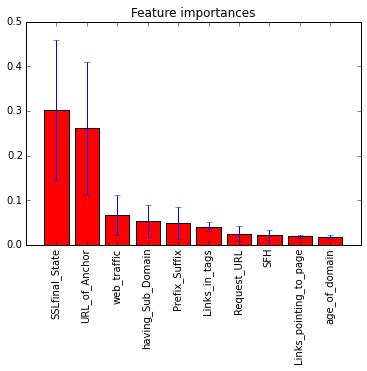

In [8]:
forest = ensemble.ExtraTreesClassifier(n_estimators=100,
                                       random_state=42)

forest.fit(train, target)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, 
                                   train.columns[indices[f]], 
                                   importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(10), train.columns[indices], rotation=90)
plt.xlim([-1, 10])
plt.show()

Here the height of the bar represents the absolute value of feature importance, while the error bar represent the standard deviation among all the tress for that variable. The plot suggests that two features, namely SSLfinal_State and URL_of_Anchor capture most of the variability in the data, but this estimation has high variance.

## 4 Partial dependence

**Partial dependence plots (PDP)** show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response [1] as a function of the ‘target’ features [2].

Due to the limits of human perception the size of the target feature set must be small (usually, one or two) thus the target features are usually chosen among the most important features.

The Figure below shows four one-way and one two-way partial dependence plots for the California housing dataset: the target variables for the one-way PDP are: median income (MedInc), avg. occupants per household (AvgOccup), median house age (HouseAge), and avg. rooms per household (AveRooms).

We can clearly see that the median house price shows a linear relationship with the median income (top left) and that the house price drops when the avg. occupants per household increases (top middle). The top right plot shows that the house age in a district does not have a strong influence on the (median) house price; so does the average rooms per household. The tick marks on the x-axis represent the deciles of the feature values in the training data.

The two-way partial dependence plot shows the dependence of median house price on joint values of house age and avg. occupants per household. We can clearly see an interaction between the two features: For an avg. occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than two there is a strong dependence on age.

For classification you can think of it as the regression score before the link function:

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing

# fetch California housing dataset
cal_housing = fetch_california_housing()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names
clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                learning_rate=0.1, loss='huber', random_state=1)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1,
             loss='huber', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=1, subsample=1.0, verbose=0, warm_start=False)

In [19]:
import warnings
warnings.filterwarnings('ignore', category=UnicodeWarning)

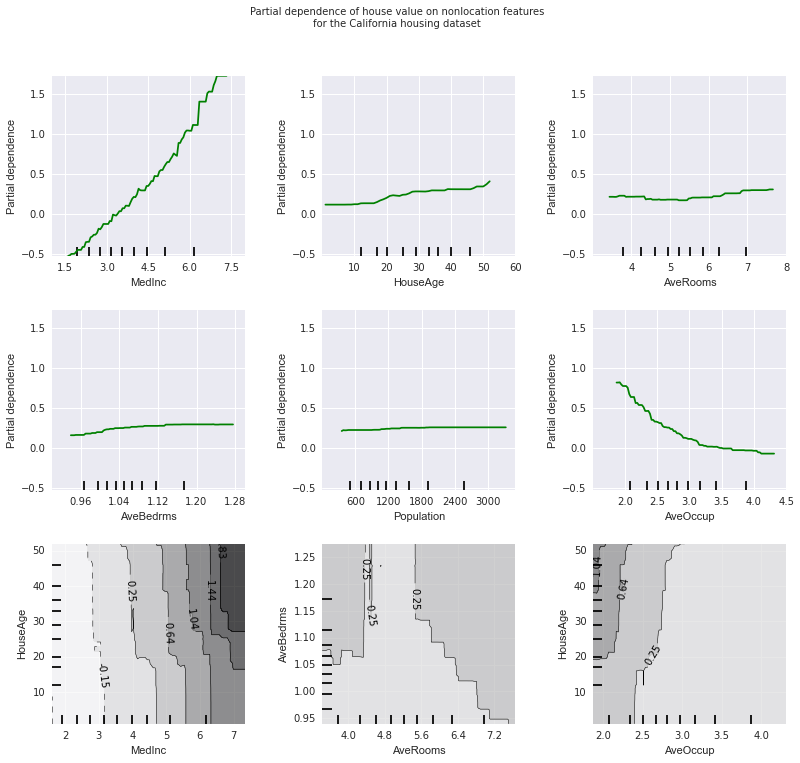

In [20]:
# sklearn uses Matplotlib for its plotting functions (like `plot_partial_dependence')
%matplotlib inline
import matplotlib.pyplot as plt 

features = [0, 1, 2, 3, 4, 5, (0,1), (2,3), (5, 1)]
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=-1, grid_resolution=100, ax=ax)
fig.suptitle('Partial dependence of house value on nonlocation features\n'
             'for the California housing dataset')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

##5 R randomForest package
In this section we provide a comparison example with `randomForest` package in **R** and its main differences with the scikit-learn implementation. R does not offer a complete container and a standard interface to Machine Learning algorithms like scikit-learn thus each algorithm has its own package and its own interface. As dispersive as it may seem it has the advantage that each algorithm can be tweaked beyond the standard implementation and can offer several additional tricks.

It is possible to use **R** directly from **Python** with the module [rpy2](http://rpy.sourceforge.net/), with results that can be passed back and forth between the two languages. It seems a fairly robust and well maintaned.

In [21]:
%load_ext rpy2.ipython

The command above load an extension for ipython with rpy2 and allows ipython notebook to interpret R syntax to be used whithin the notebook (using the magic `%R`)

In [40]:
%R library(randomForest)
%R library(foreign)
%R data <- read.arff("example_data/Training Dataset.arff")
%R print("Data loaded")

[1] "Data loaded"


In [23]:
%R rfc <- randomForest(Result ~., data=data, importance=T, proximity=T)
%R print(rfc)


Call:
 randomForest(formula = Result ~ ., data = data, importance = T,      proximity = T) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 3.18%
Confusion matrix:
      1   -1 class.error
1  6021  136  0.02208868
-1  216 4682  0.04409963


Calling the randomForest method returns an object that contains all the information about the results, such as formula, error rate, confusion matrix, importance, etc. Each piece of information can be retrieved either by printing a summary of the object or with a specific function (or accessing the corresponding variable in the data structure directly). For example it is possibile to retrieve information about variable importance with the command `importance`.

### 5.1 Variable importance

The package randomForest in R has both methods for assessing variable importance, that is the one based on gini index (the same used in scikit-learn) and the one based on accuracy (shuffling of OOB variables) described in the original Breiman paper. The latter method is the one regarded as the most accurate in the literature (and for which it is possible to derive formal measure of accuracy).

In [28]:
%R print(importance(rfc, type=1))

                            MeanDecreaseAccuracy
having_IP_Address                       37.84971
URL_Length                              33.13857
Shortining_Service                      22.77228
having_At_Symbol                        29.42179
double_slash_redirecting                24.27593
Prefix_Suffix                           47.71638
having_Sub_Domain                       65.56655
SSLfinal_State                          98.92088
Domain_registeration_length             36.01868
Favicon                                 23.90817
port                                    17.41523
HTTPS_token                             28.84068
Request_URL                             38.89691
URL_of_Anchor                           84.60386
Links_in_tags                           80.73104
SFH                                     47.59320
Submitting_to_email                     33.26789
Abnormal_URL                            25.93446
Redirect                                28.94208
on_mouseover        

In [29]:
%R print(importance(rfc, type=2))

                            MeanDecreaseGini
having_IP_Address                  56.004992
URL_Length                         37.111876
Shortining_Service                 24.070429
having_At_Symbol                   19.742534
double_slash_redirecting           17.604583
Prefix_Suffix                     252.895276
having_Sub_Domain                 300.780777
SSLfinal_State                   1669.699777
Domain_registeration_length        76.500378
Favicon                            20.253694
port                               12.973888
HTTPS_token                        24.575130
Request_URL                        95.202956
URL_of_Anchor                    1290.710240
Links_in_tags                     192.897491
SFH                                98.947781
Submitting_to_email                23.904318
Abnormal_URL                       20.227690
Redirect                           22.110939
on_mouseover                       16.096184
RightClick                          7.311073
popUpWidno

As can be seen in the plot below, there is not much difference in this two type of importances, at least for this dataset. However, some of the least important features are mixed up.

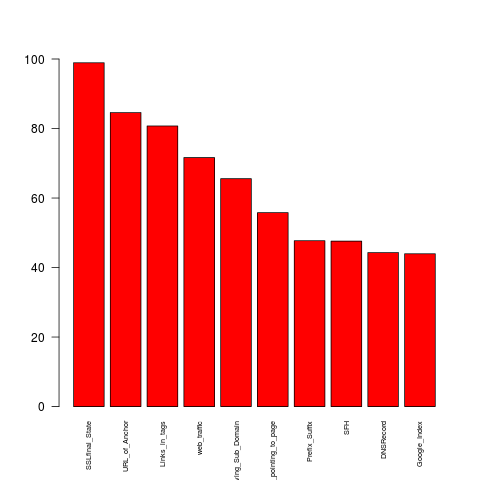

[1] "MeanDecreaseAccuracy"


In [78]:
#%R imp = importance(rfc, type = 1)
#%R barplot(imp[order(-imp)[1:10],1], cex.names=0.6, las=2, col="red", ylim=c(0,100))
%R imp <- rfc$importance[,3] / rfc$importanceSD[,3]
%R impOrd <- order(-imp)
%R barplot(imp[impOrd[1:10]], cex.names=0.6, las=2, col="red", ylim=c(0,100))
%R print("MeanDecreaseAccuracy")

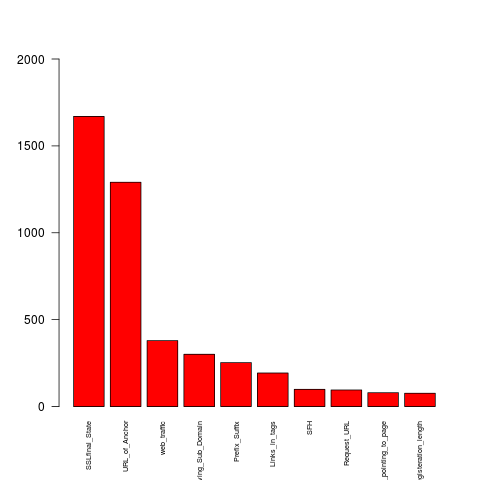

[1] "MeanDecreaseGini"


In [68]:
%R barplot(rfc$importance[order(-rfc$importance[,4])[1:10],4], cex.names=0.6, las=2, col="red", ylim=c(0, 2000))
%R print("MeanDecreaseGini")

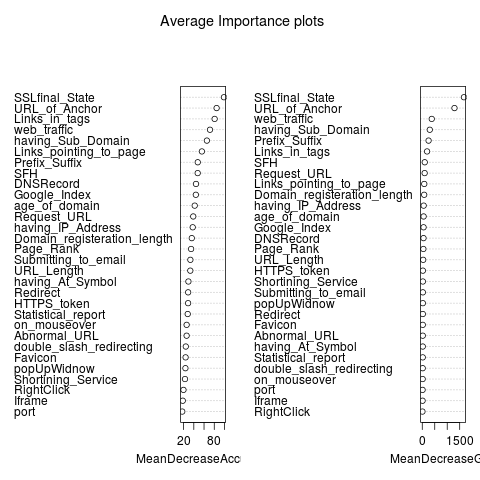

[1] "Average Importance plots"


In [76]:
%R varImpPlot(rfc, main=" Average Importance plots")
%R print("Average Importance plots")

In **R**, there are many ways (and many functions) for plotting each plot. `varImpPlot` is a function that automatically plots variable importance with axis exchanged for better reading (feature names are read more easily if horizontal).

### 5.2 Feature selection

With the package `varSelRF` it is possible to use Random Forests to automatically choose the best subset of variables among that in the dataset. It is an automatical procedure in which at each itearation the least important variables are discarded until the OOB score stop to decrease. 

In [38]:
%R library(varSelRF)
%R rf.vs1 = varSelRF(data[,-(ncol(data))], data[,ncol(data)], ntree = 200, ntreeIterat = 100, vars.drop.frac = 0.2, mtryFactor = 5)
#command:
#rf.vs1 = varSelRF(data[,-(ncol(data))], 
#                  data[,ncol(data)], 
#                  ntree = 200, 
#                  ntreeIterat = 100, 
#                  vars.drop.frac = 0.2, 
#                  mtryFactor = 5)
%R print(rf.vs1)


Backwards elimination on random forest; ntree =  200 ;  mtryFactor =  5 

 Selected variables:
 [1] "age_of_domain"               "DNSRecord"                  
 [3] "Domain_registeration_length" "double_slash_redirecting"   
 [5] "Favicon"                     "Google_Index"               
 [7] "having_IP_Address"           "having_Sub_Domain"          
 [9] "HTTPS_token"                 "Iframe"                     
[11] "Links_in_tags"               "Links_pointing_to_page"     
[13] "on_mouseover"                "Page_Rank"                  
[15] "popUpWidnow"                 "Prefix_Suffix"              
[17] "Request_URL"                 "SFH"                        
[19] "Shortining_Service"          "SSLfinal_State"             
[21] "Submitting_to_email"         "URL_Length"                 
[23] "URL_of_Anchor"               "web_traffic"                

 Number of selected variables: 24 



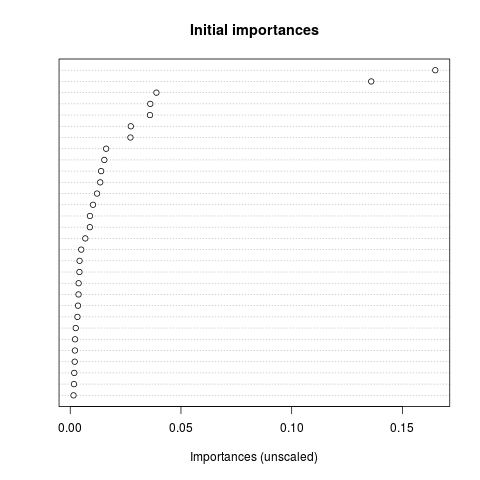

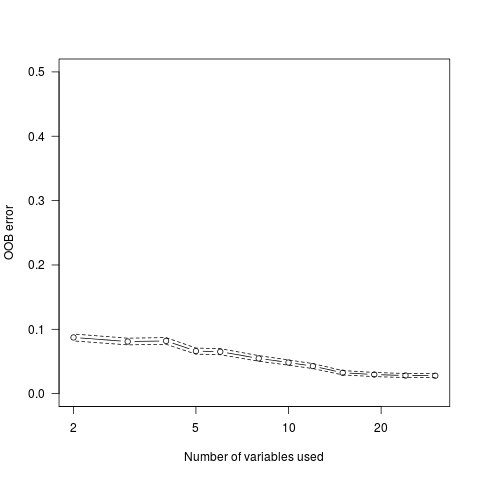

In [39]:
%R plot(rf.vs1)

This picture shows the initial variable importances and the change in OOB error corresponding to the number of variables used. 

### 5.3 Proximity plot

If the parameter proximity is set to True, during the process of growing a random forest, an $N \times N$ proximity matrix is accumulated for the training data. For every tree, any pair of oob observations sharing a leaf has their proximity increased. The matrix is then scaled to be represented in two dimensions. Proximity plot gives an indication of which observation are effectively close as learned by the random forest classifier.

Proximity plots for random forests often look very similar they tend to have a star shape,
one arm per class, which is more pronounced the better the classification
performance.

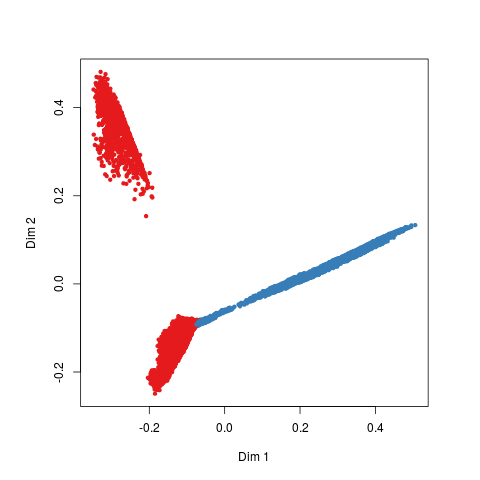

[1] "Multi-dimensional Scaling Plot of Proximity matrix from randomForest"


In [41]:
%R MDSplot(rfc, data[,ncol(data)])
%R print("Multi-dimensional Scaling Plot of Proximity matrix from randomForest")

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.